<a href="https://colab.research.google.com/github/rubygitflow/Sequence-to-Sequence-training-models/blob/master/University_of_Artificial_Intelligence_NLP_HomeWork_6_Pro_Seq2Seq_Chat_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP.Lesson 6.Seq2Seq. Chat-bot

1. Seq2Seq модель для построения чатбота на Keras. http://www.bizkit.ru/2020/06/25/18150/ 

2. Простой чатбот на нейронной сети. Keras. http://www.bizkit.ru/2020/02/14/16659/ 

3. How to implement Seq2Seq LSTM Model in Keras. https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

4. A ten-minute introduction to sequence-to-sequence learning in Keras. https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html


In [1]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Checking the GPU

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import os
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
if len(GPUs)>0:
  gpu = GPUs[0]
else:
  print('GPU turned off')
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM FREE: "+humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  if len(GPUs)>0:
    print("Gen RAM FREE: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    print("GPU Model: " + gpu.name)

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=781fd27b546e22eb0a6d189f47e652fa528935767affa55bc48a9dd625c485d1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM FREE: 12.7 GB  | Proc size: 365.6 MB
Gen RAM FREE: 15079MB | Used: 0MB | Util   0% | Total 15079MB
GPU Model: Tesla T4


## Data Setting

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
dir = '/content/drive/My Drive/Базы/NLP/База для чат-ботов/'
def read_text(filename):
  with open(dir+filename, 'r') as f:
    text = f.read()
    text = text.replace('\ufeff', '')  
    text = re.sub(r'[^А-я-]', ' ', text)
  print(text[:300])  
  return '\n' + text


In [5]:
all_text = read_text('9700 диалоги художка+быт.txt')

- - Как вы можете быть таким уверенным  - Элементарно   - - А что делать будем  - Ждать  - - Надеюсь  не до первой звезды  - Я тоже на это надеюсь   - - За что  - Вы знаете за что   - - Ты что-нибудь понимаешь  - Абсолютно ничего   - - Обсудим это завтра  ладно  - Хорошо   - - Кто услышит  - Кто-кто


In [6]:
all_text += read_text('5400 диалог политика+ художка -военные, бемби, незнайкак, донцова,анекдот, пух и прочие.txt')

- - Ой  а почему у вас в кармане сыро  - Так полагается   - - Когда начинаеться сезон фрукта Манго          - Сезон длятся круглогодично  пик в Таиланде с марта по май  во Вьетнаме зимой и весной  в Индонезии с сентября по декабрь   - - Чем характеризуется   -я неделя беремености  - Вес тела женщины


In [7]:
all_text += read_text('1200.txt')

- - Каковы последствия поражения мозжечка  - Типичной для поражения мозжечка является мышечная гипотония  - - Что кушают молодые гадюки  - Молодые гадюки в основном кормятся рептилиями и земноводными  - - Что такое лиссосфинктеры  - Гладкомышечные непроизвольные сфинктеры называются  лиссосфинктерам


In [8]:
all_text += read_text('8 тыс диалоги болталка, общее, энциклопедия разные науки, тесты школьные.txt')

- - Как дела  - Все хорошо   - - Где ты живешь  - Я живу во Вселенной   - - Где я живу  - Ты живешь на планете Земля   - - Сколько тебе лет  - Я молод и постоянно учусь  что бы помочь тебе   - - Ты любишь музыку  - Да  люблю   - - Какую музыку ты любишь  - Все зависит от настроения   - - Вас когда-н


In [10]:
QnA = all_text.split('- -')[1:]

In [11]:
questions = []
answers = []
k = 0
for el in QnA:
  try:
    q, a = el.split('-')
    questions.append(q)
    answers.append(a)
  except ValueError:
    k+=1

In [12]:
k

4008

In [13]:
enc_in = ['<START> '+ q for q in questions]

In [14]:
enc_in[:10]

['<START>  Как вы можете быть таким уверенным  ',
 '<START>  А что делать будем  ',
 '<START>  Надеюсь  не до первой звезды  ',
 '<START>  За что  ',
 '<START>  Обсудим это завтра  ладно  ',
 '<START>  Ну я пойду  ',
 '<START>  Может  стоило ее предупредить  ',
 '<START>  А вы тут  что ли  не одна живете  ',
 '<START>  В рублях или долларах  ',
 '<START>  А теперь  значит  он уже столичная штучка  ']

In [15]:
decoder_in = ['<START> ' + a for a in answers]
decoder_out = [a + ' <END>' for a in answers]

In [16]:
decoder_in[:10]

['<START>  Элементарно   ',
 '<START>  Ждать  ',
 '<START>  Я тоже на это надеюсь   ',
 '<START>  Вы знаете за что   ',
 '<START>  Хорошо   ',
 '<START>  А  Иди  иди  Постой     ',
 '<START>  Может   ',
 '<START>  Нет  я живу здесь не одна   ',
 '<START>  В долларах  конечно   ',
 '<START>  Ну да  А что  ты его знаешь   ']

In [ ]:
decoder_out[:10]

[' Элементарно    <END>',
 ' Ждать   <END>',
 ' Я тоже на это надеюсь    <END>',
 ' Вы знаете за что    <END>',
 ' Хорошо    <END>',
 ' А  Иди  иди  Постой      <END>',
 ' Может    <END>',
 ' Нет  я живу здесь не одна    <END>',
 ' В долларах  конечно    <END>',
 ' Ну да  А что  ты его знаешь    <END>']

In [17]:
num_words = 10000
tokenizer = Tokenizer(num_words, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<UNK>')

In [18]:
tokenizer.fit_on_texts(enc_in)
tokenizer.fit_on_texts(decoder_in)
tokenizer.fit_on_texts(decoder_out)

In [20]:
tokenizer.index_word

{1: '<UNK>',
 2: '<start>',
 3: '<end>',
 4: 'в',
 5: 'не',
 6: 'что',
 7: 'и',
 8: 'я',
 9: 'ты',
 10: 'на',
 11: 'а',
 12: 'это',
 13: 'да',
 14: 'как',
 15: 'нет',
 16: 'с',
 17: 'у',
 18: 'вы',
 19: 'кто',
 20: 'так',
 21: 'все',
 22: 'же',
 23: 'ну',
 24: 'из',
 25: 'где',
 26: 'он',
 27: 'к',
 28: 'меня',
 29: 'мне',
 30: 'по',
 31: 'тебя',
 32: 'за',
 33: 'для',
 34: 'от',
 35: 'есть',
 36: 'или',
 37: 'можно',
 38: 'такое',
 39: 'его',
 40: 'знаю',
 41: 'чем',
 42: 'конечно',
 43: 'тебе',
 44: 'какой',
 45: 'ничего',
 46: 'может',
 47: 'о',
 48: 'там',
 49: 'еще',
 50: 'ли',
 51: 'мы',
 52: 'почему',
 53: 'чего',
 54: 'очень',
 55: 'куда',
 56: 'бы',
 57: 'она',
 58: 'мл',
 59: 'здесь',
 60: 'если',
 61: 'когда',
 62: 'вот',
 63: 'но',
 64: 'вас',
 65: 'только',
 66: 'сейчас',
 67: 'вам',
 68: 'сколько',
 69: 'они',
 70: 'надо',
 71: 'то',
 72: 'до',
 73: 'зачем',
 74: 'их',
 75: 'хочешь',
 76: 'при',
 77: 'ее',
 78: 'хорошо',
 79: 'обозначение',
 80: 'какие',
 81: 'люблю',
 82

In [37]:
len(tokenizer.index_word)

32454

In [21]:
X_enc = tokenizer.texts_to_sequences(enc_in)

In [22]:
X_enc

[[2, 14, 18, 517, 84, 1157, 1],
 [2, 11, 6, 119, 214],
 [2, 598, 5, 72, 695, 715],
 [2, 32, 6],
 [2, 6747, 12, 279, 258],
 [2, 23, 8, 542],
 [2, 46, 2997, 77, 5783],
 [2, 11, 18, 85, 6, 50, 5, 268, 2681],
 [2, 4, 1, 36, 9750],
 [2, 11, 134, 117, 26, 87, 1, 9751],
 [2, 376, 11, 10, 1, 31, 37, 1],
 [2, 6, 1],
 [2, 9, 6, 4512],
 [2, 53, 43],
 [2, 11, 18, 1267, 19],
 [2, 7, 14, 29, 77, 459, 25, 57, 66, 421],
 [2, 1, 846, 77, 5784],
 [2, 9, 6, 1876, 4, 670],
 [2, 23, 20, 8, 542],
 [2, 23, 7, 6],
 [2, 11, 121, 57, 17, 31, 251, 9752],
 [2, 46, 124, 323, 3344, 10, 1349],
 [2, 6, 12],
 [2, 57, 57, 1111],
 [2, 6, 962, 118, 1218],
 [2, 87, 37],
 [2, 20, 29, 4513, 507, 262],
 [2, 4, 44, 57, 2998],
 [2, 9, 25, 89],
 [2, 71, 35, 14, 12, 2482],
 [2, 19, 77, 847],
 [2, 19, 48],
 [2, 9, 6, 569],
 [2, 11, 4514],
 [2, 6, 797],
 [2, 25],
 [2, 23, 14, 16, 1],
 [2, 1, 19, 12],
 [2, 6],
 [2, 5, 607, 1419],
 [2, 4, 41, 130],
 [2, 67, 1],
 [2, 6],
 [2, 9],
 [2, 9, 1628],
 [2, 11, 168, 35],
 [2, 11, 25, 69],
 [

In [23]:
X_enc.__len__()

19316

In [24]:
X_dec = tokenizer.texts_to_sequences(decoder_in)
Y = tokenizer.texts_to_sequences(decoder_out)

In [25]:
X_dec.__len__()

19316

In [26]:
Y.__len__()

19316

In [27]:
max_q_len = max([len(el) for el in X_enc]); max_q_len

34

In [28]:
max_a_len = max([len(el) for el in X_dec]); max_a_len

200

In [29]:
X_enc = pad_sequences(X_enc, max_q_len, padding='post', truncating='post')
X_dec = pad_sequences(X_dec, max_a_len, padding='post', truncating='post')
Y = pad_sequences(Y, max_a_len, padding='post', truncating='post')

In [30]:
X_enc.shape

(19316, 34)

In [31]:
X_enc

array([[  2,  14,  18, ...,   0,   0,   0],
       [  2,  11,   6, ...,   0,   0,   0],
       [  2, 598,   5, ...,   0,   0,   0],
       ...,
       [  2,  92,   1, ...,   0,   0,   0],
       [  2,   6,  38, ...,   0,   0,   0],
       [  2,   6,  38, ...,   0,   0,   0]], dtype=int32)

In [32]:
hidden_dim = 256
emb_size = 256

# LSTM

## Modelling. Training.

In [33]:
lstm_encoder_input = Input((None,))
lstm_enc_emb = Embedding(num_words, emb_size, name='emb_enc', input_length=max_q_len + 1)(lstm_encoder_input)
_, *lstm_states = LSTM(hidden_dim, return_state=True, name='lstm_enc')(lstm_enc_emb)

lstm_encoder = Model(lstm_encoder_input, lstm_states)

lstm_decoder_input = Input((None,))
lstm_dec_emb = Embedding(num_words, emb_size, name='emb_dec', input_length=max_a_len + 1)(lstm_decoder_input)
lstm_dec = LSTM(hidden_dim, return_sequences=True, name='lstm_dec')(lstm_dec_emb, initial_state = lstm_states)
lstm_dec_out = Dense(num_words, activation='softmax', name='dense')(lstm_dec)

lstm_seq2seq = Model([lstm_encoder_input, lstm_decoder_input], lstm_dec_out)

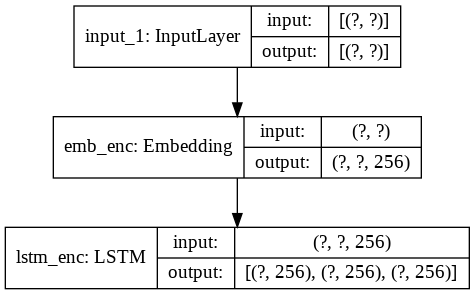

In [34]:
plot_model(lstm_encoder, show_shapes=True)

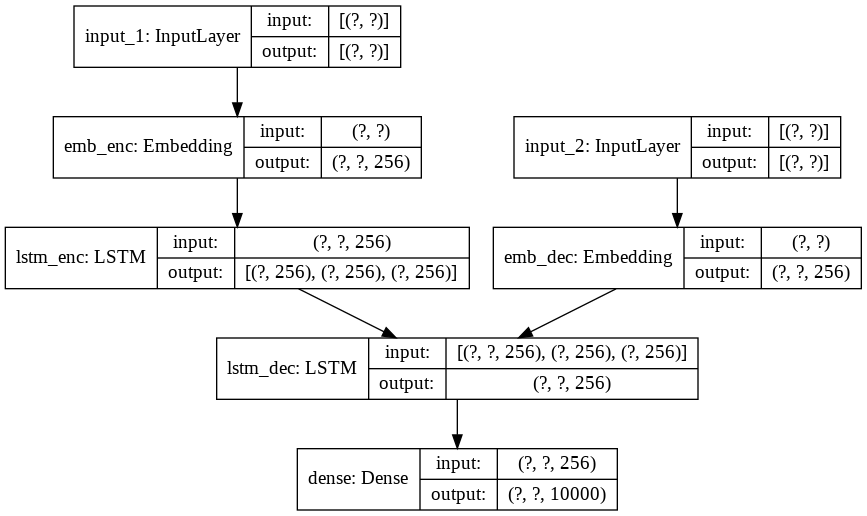

In [35]:
plot_model(lstm_seq2seq, show_shapes=True)

In [38]:
lstm_seq2seq.compile(loss="sparse_categorical_crossentropy", optimizer='RMSProp', metrics=['sparse_categorical_accuracy'])

In [39]:
lstm_seq2seq.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
emb_enc (Embedding)             (None, None, 256)    2560000     input_1[0][0]                    
__________________________________________________________________________________________________
emb_dec (Embedding)             (None, None, 256)    2560000     input_2[0][0]                    
_______________________________________________________________________________________

In [40]:
history_lstm = lstm_seq2seq.fit([X_enc, X_dec], Y, batch_size=30, epochs=100, validation_split=0.2)
lstm_seq2seq.save( '/content/drive/My Drive/tmp/lstm_seq2seq_100epochs(rms).h5' )

Epoch 1/100
516/516 [==============================] - 81s 157ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.2831 - val_sparse_categorical_accuracy: 0.9644
Epoch 2/100
516/516 [==============================] - 81s 157ms/step - loss: 0.1353 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.9656
Epoch 3/100
516/516 [==============================] - 81s 157ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.2749 - val_sparse_categorical_accuracy: 0.9655
Epoch 4/100
516/516 [==============================] - 82s 158ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.2704 - val_sparse_categorical_accuracy: 0.9657
Epoch 5/100
516/516 [==============================] - 82s 158ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.2768 - val_sparse_categorical_accuracy: 0.9658
Epoch 6/100
516/516 [==============================] - 82s 158ms/step - loss: 0.

In [43]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.grid(True)
  plt.show()

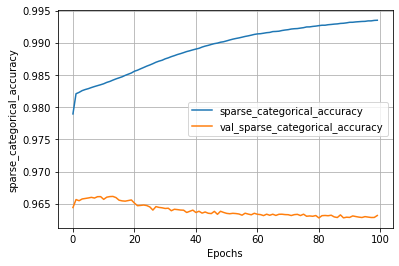

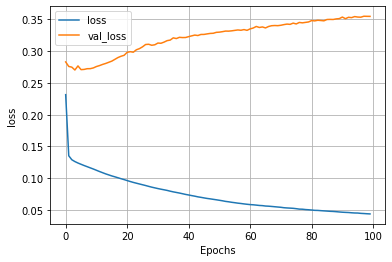

In [42]:
plot_graphs(history_lstm, "sparse_categorical_accuracy")
plot_graphs(history_lstm, "loss")

## Testing. Rigid inference model.

In [46]:
lstm_decoder_input = Input((None,))
h_input = Input((hidden_dim,))
c_input = Input((hidden_dim,))

lstm_states = [h_input, c_input]
# insert the newly calculated weights into the neural network layer
lstm_dec_emb = Embedding(num_words, hidden_dim, weights=lstm_seq2seq.get_layer(name='emb_dec').get_weights(), name='emb_dec')(lstm_decoder_input)
lstm, lstm_h, lstm_c = LSTM(hidden_dim, return_state=True, weights=lstm_seq2seq.get_layer(name='lstm_dec').get_weights(), name='lstm_dec')(lstm_dec_emb, initial_state=lstm_states)
lstm_out = Dense(num_words, activation='softmax', weights=lstm_seq2seq.get_layer(name='dense').get_weights(), name='dense')(lstm)

lstm_decoder = Model([lstm_decoder_input]+lstm_states, [lstm_out, lstm_h, lstm_c])

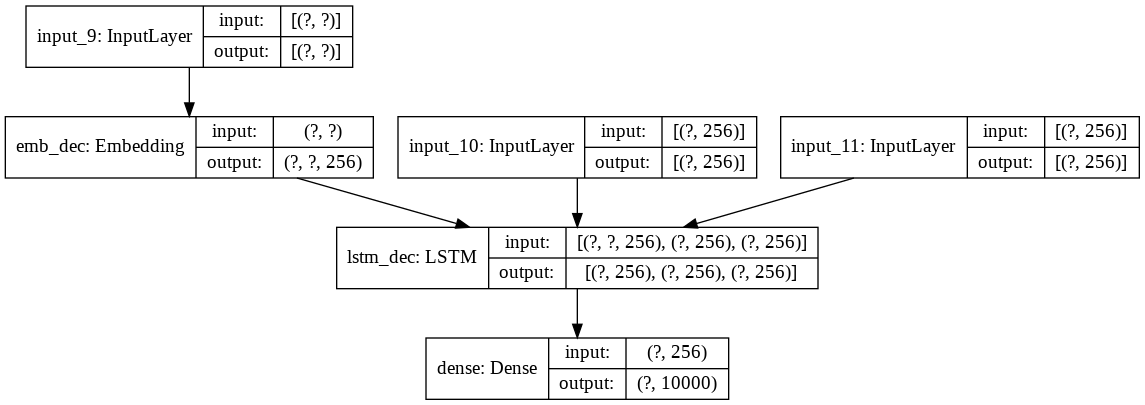

In [47]:
plot_model(lstm_decoder, show_shapes=True)

In [48]:
np.all(lstm_decoder.get_layer(name='dense').get_weights()[1] == lstm_seq2seq.get_layer(name='dense').get_weights()[1])

True

In [49]:
# function of prediction 
def lstm_decode_sequence(input_seq): # input sequence from tokens

  # returning the state [h, c]
  states = lstm_encoder.predict(input_seq)

  prev_token = np.zeros((1,1))
  # assign a value to the first character "start"
  prev_token[0,0] = tokenizer.word_index['<start>']


  # stop flag
  Flag = False
  # reset the sentence
  decoded_sentence = ''

  while not Flag:
    pred, *states= lstm_decoder.predict([prev_token] + states)
    
    # converting the decoded token to a character 
    next_token = np.argmax(pred, axis=-1) #

    sampled_word = tokenizer.sequences_to_texts([next_token])[0]

    decoded_sentence += sampled_word +' '

    # if we find the last character in the word or exceed the length of the word
    if (sampled_word == '<end>' or
      len(decoded_sentence.split()) > max_a_len+1):
      print(pred.shape)
      Flag = True

    prev_token[0,0] = next_token

  return decoded_sentence

In [50]:
sent = 'вы вызывали'
sent = '<start> ' + sent
x = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=max_a_len, padding='post', truncating='post')
print(lstm_decode_sequence(x))

(1, 10000)
так точно <end> 


In [51]:
sent = 'ты потянешь несколько курсов одновременно'
sent = '<start> ' + sent
x = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=max_a_len, padding='post', truncating='post')
print(lstm_decode_sequence(x))

(1, 10000)
уверен <end> 


In [52]:
sent = 'что будет если завернуть мясо в лепешку'
sent = '<start> ' + sent
x = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=max_a_len, padding='post', truncating='post')
print(lstm_decode_sequence(x))

(1, 10000)
еще один <UNK> <UNK> <end> 


# Conv1D

## Modelling. Training.

In [53]:
conv_encoder_input = Input((None,))
conv_enc_emb = Embedding(num_words, emb_size, name='emb_enc', input_length=max_q_len + 1)(conv_encoder_input)
conv_enc = Conv1D(hidden_dim, 25, activation='relu', padding='same', strides=1, name='Conv1D_enc')(conv_enc_emb)
conv_states = GlobalMaxPooling1D(name='MaxPooling1D_enc')(conv_enc)
conv_encoderStates = [conv_states] # Important!

conv_encoder = Model(conv_encoder_input, conv_encoderStates)

conv_decoder_input = Input((None,))
conv_dec_emb = Embedding(num_words, emb_size, name='emb_dec', input_length=max_a_len + 1)(conv_decoder_input)
conv_dec, _ = GRU(hidden_dim, return_sequences=True, return_state=True, name='GRU_dec')(conv_dec_emb, initial_state = conv_encoderStates) # return_state - It's important for the complete output!
conv_dec_out = Dense(num_words, activation='softmax', name='dense')(conv_dec)

conv_seq2seq = Model(inputs=[conv_encoder_input, conv_decoder_input], outputs=conv_dec_out)


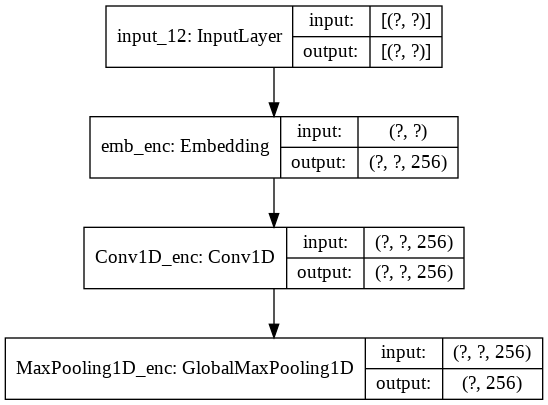

In [54]:
plot_model(conv_encoder, show_shapes=True)

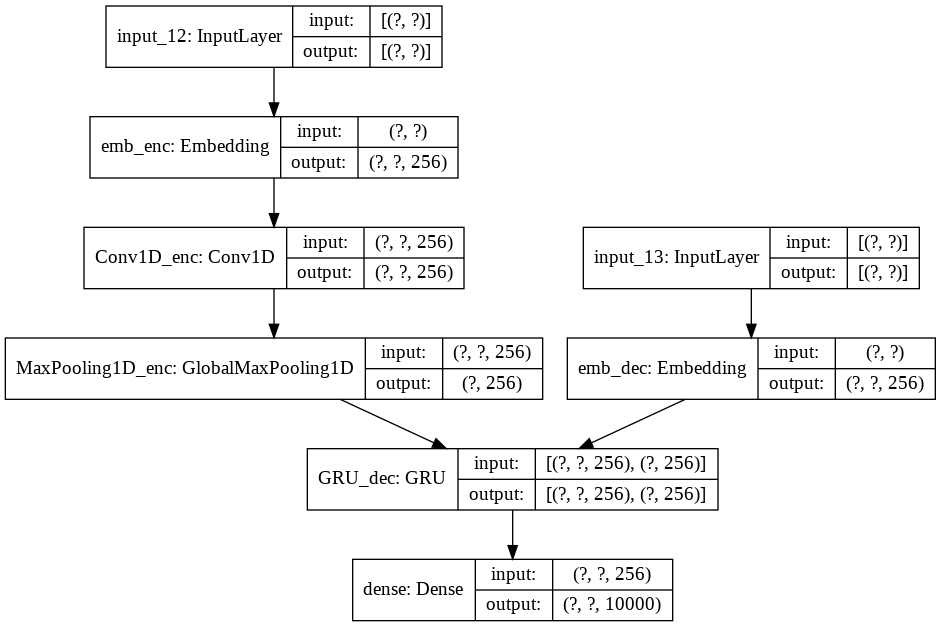

In [55]:
plot_model(conv_seq2seq, show_shapes=True)

In [56]:
conv_seq2seq.compile(loss="sparse_categorical_crossentropy", optimizer='RMSProp', metrics=['sparse_categorical_accuracy'])

In [57]:
conv_seq2seq.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
emb_enc (Embedding)             (None, None, 256)    2560000     input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
Conv1D_enc (Conv1D)             (None, None, 256)    1638656     emb_enc[0][0]                    
_______________________________________________________________________________________

In [58]:
history_Conv_GRU = conv_seq2seq.fit([X_enc, X_dec], Y, batch_size=64, epochs=100, validation_split=0.2)
lstm_seq2seq.save( '/content/drive/My Drive/tmp/conv_seq2seq_100epochs(rms).h5' )

Epoch 1/100
242/242 [==============================] - 70s 291ms/step - loss: 0.3062 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.2812 - val_sparse_categorical_accuracy: 0.9647
Epoch 2/100
242/242 [==============================] - 70s 291ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.2753 - val_sparse_categorical_accuracy: 0.9658
Epoch 3/100
242/242 [==============================] - 71s 294ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9663
Epoch 4/100
242/242 [==============================] - 72s 296ms/step - loss: 0.1215 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.2709 - val_sparse_categorical_accuracy: 0.9664
Epoch 5/100
242/242 [==============================] - 72s 296ms/step - loss: 0.1183 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.2715 - val_sparse_categorical_accuracy: 0.9661
Epoch 6/100
242/242 [==============================] - 72s 296ms/step - loss: 0.

In [59]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.grid(True)
  plt.show()

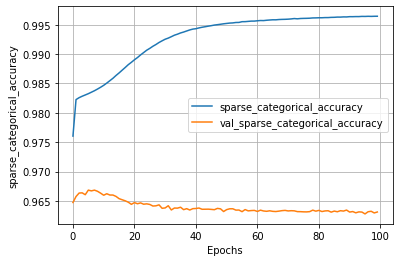

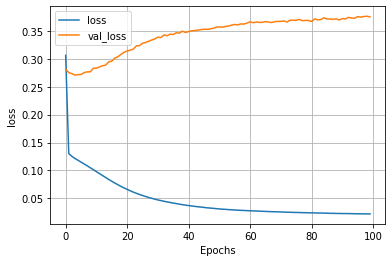

In [60]:
plot_graphs(history_Conv_GRU, "sparse_categorical_accuracy")
plot_graphs(history_Conv_GRU, "loss")

## Testing. Rigid inference model.

In [61]:
conv_decoder_input = Input((None,))
conv_c_input = Input((hidden_dim,))

# insert the newly calculated weights into the neural network layer
conv_dec_emb = Embedding(num_words, emb_size, weights=conv_seq2seq.get_layer(name='emb_dec').get_weights(), name='emb_dec', input_length=max_a_len + 1)(conv_decoder_input)
gru, gru_c = GRU(hidden_dim, return_sequences=True, return_state=True, weights=conv_seq2seq.get_layer(name='GRU_dec').get_weights(), name='GRU_dec')(conv_dec_emb, initial_state = conv_c_input) # return_state - It's important for the complete output!
conv_out = Dense(num_words, activation='softmax', weights=conv_seq2seq.get_layer(name='dense').get_weights(), name='dense')(gru)

conv_decoder = Model([conv_decoder_input, conv_c_input], [conv_out, gru_c])

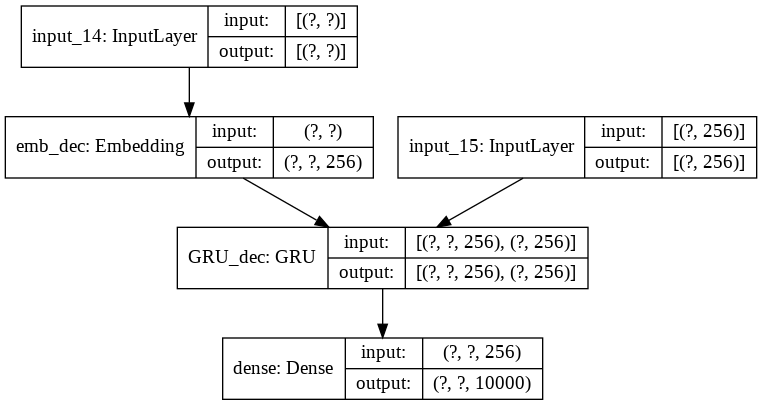

In [62]:
plot_model(conv_decoder, show_shapes=True)

In [63]:
np.all(conv_decoder.get_layer(name='dense').get_weights()[1] == conv_seq2seq.get_layer(name='dense').get_weights()[1])

True

In [73]:
# function of prediction 
def conv_decode_sequence(input_seq): # input sequence from tokens
  # returning the state [h, c]
  states = conv_encoder.predict(input_seq)

  prev_token = np.zeros(1)
  # assign a value to the first character "start"
  prev_token[0] = tokenizer.word_index['<start>']

  # stop flag
  Flag = False
  # reset the sentence
  decoded_sentence = ''

  while not Flag:
    pred, states= conv_decoder.predict([prev_token, states])
    
    # converting the decoded token to a character 
    next_token = np.argmax(pred, axis=-1) #

    sampled_word = tokenizer.sequences_to_texts(next_token)[0]

    # if we find the last character in the word or exceed the length of the word
    if sampled_word == '<end>':
      Flag = True
    else:
      decoded_sentence += sampled_word + ' '

      if len(decoded_sentence.split()) > max_a_len + 1:
        Flag = True

    # update the predicted value
    prev_token = np.zeros(1)
    prev_token[0] = next_token

  return decoded_sentence.capitalize()


In [69]:
def predict_answer(text):
  sent = re.sub(r'[^А-я-]', ' ', text)
  sent = '<start> ' + sent.lower()
  x = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=max_a_len + 1, padding='post', truncating='post')
  print(conv_decode_sequence(x))

In [74]:
predict_answer('Вы вызывали?')

Да мадам 


In [75]:
predict_answer('Ты потянешь несколько курсов одновременно?')

Я <unk> не <unk> 


In [76]:
predict_answer('Что будет, если завернуть мясо в лепешку?')

Ну мне всегда сюда будет 
